# Sistema de Recomendação para Spotify

### Contexto da Avaliação

Nesta avaliação, o objetivo é criar um sistema de recomendação para melhorar a experiência dos usuários do Spotify e de outras plataformas de streaming. Utilizamos dados de músicas, artistas e plataformas de streaming, como Spotify, Apple Music e Deezer. Através desse dataset, buscamos entender como diferentes músicas se comportam nessas plataformas e criar recomendações inteligentes baseadas em suas características.

#### Dataset:

O dataset fornecido contém informações detalhadas sobre as músicas, incluindo:
- `track_name`: Nome da música
- `artist(s)_name`: Nome dos artistas
- `artist_count`: Número de artistas envolvidos
- `released_year`, `released_month`, `released_day`: Data de lançamento da música
- `in_spotify_playlists`, `in_spotify_charts`, `streams`: Popularidade da música no Spotify
- `in_apple_playlists`, `in_apple_charts`: Popularidade da música no Apple Music
- `in_deezer_playlists`, `in_deezer_charts`: Popularidade no Deezer
- Características musicais como `bpm`, `key`, `mode`, `danceability_%`, `valence_%`, `energy_%`, `acousticness_%`, entre outras.

Com base nesses dados, podemos realizar uma série de análises e criar um sistema de recomendação eficiente.

### Objetivos:

1. **Análise Musical**: Explorar padrões em recursos de áudio para entender tendências musicais e preferências em músicas populares.
2. **Comparação entre Plataformas**: Comparar a popularidade de uma música em diferentes plataformas (Spotify, Apple Music, Deezer).
3. **Impacto do Artista**: Analisar como o envolvimento dos artistas está relacionado ao sucesso de uma música.
4. **Recomendações Baseadas em Conteúdo**: Utilizar características musicais para recomendar músicas semelhantes.

### Ferramentas Utilizadas

Este projeto utiliza as seguintes bibliotecas de Python:
- **Pandas**: Para manipulação e análise de dados.
- **Matplotlib** e **Seaborn**: Para visualização de dados.
- **Scikit-learn**: Para realizar a normalização dos dados e calcular a similaridade entre as músicas usando a similaridade de cosseno.

A seguir, vamos realizar uma análise dos dados e desenvolver um sistema de recomendação.


### Bibliotecas

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

### Carregando o Data Frame

In [65]:
df = pd.read_csv('/content/spotify-2023.csv', encoding='ISO-8859-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## Limpeza de Dados

In [66]:
# Verificação dos Dados
print("Número de entradas:", len(df))
df.info()

Número de entradas: 953
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key             

In [67]:
# Converter as colunas 'streams', 'in_deezer_playlists' e 'in_shazam_charts' para numérico, substituindo strings por NaN
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'], errors='coerce')
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'], errors='coerce')

# Verificar se as mudanças foram aplicadas corretamente
print(df[['in_deezer_playlists', 'in_shazam_charts']].dtypes)

in_deezer_playlists    float64
in_shazam_charts       float64
dtype: object


In [68]:
# Converter as colunas 'in_deezer_playlists' e 'in_shazam_charts' para int
df['in_deezer_playlists'] = df['in_deezer_playlists'].fillna(0).astype(int)
df['in_shazam_charts'] = df['in_shazam_charts'].fillna(0).astype(int)

# Verificar se as mudanças foram aplicadas corretamente
print(df[['in_deezer_playlists', 'in_shazam_charts']].dtypes)

in_deezer_playlists    int64
in_shazam_charts       int64
dtype: object


In [69]:
# Limpeza de Dados: Explodindo a coluna de artistas
df['artist(s)_name'] = df['artist(s)_name'].str.split(', ')
df = df.explode('artist(s)_name')

# Verificação da limpeza
print("Número de entradas após a limpeza:", len(df))

# Contar o número de entradas antes da limpeza
print("Número de entradas antes da nova limpeza:", len(df))

Número de entradas após a limpeza: 1482
Número de entradas antes da nova limpeza: 1482


In [70]:
# Coluna "streams" está como tipo object, precisamos entender o motivo.
# Exibir valores únicos na coluna 'streams'
df['streams'].unique()

array(['141381703', '133716286', '140003974', '800840817', '303236322',
       '183706234', '725980112', '58149378', '95217315', '553634067',
       '505671438', '58255150', '1316855716', '387570742', '2513188493',
       '1163093654', '496795686', '30546883', '335222234', '363369738',
       '86444842', '52135248', '1297026226', '200647221', '115364561',
       '78300654', '899183384', '61245289', '429829812', '127408954',
       '22581161', '52294266', '843957510', '999748277', '618990393',
       '123122413', '188933502', '1355959075', '786181836', '176553476',
       '354495408', '2808096550', '1109433169', '1047101291', '65156199',
       '570515054', '1085685420', '1647990401', '2565529693', '518745108',
       '107753850', '177740666', '153372011', '57876440', '1813673666',
       '3703895074', '256483385', '1214083358', '16011326', '812019557',
       '111947664', '156338624', '720434240', '357925728', '674072710',
       '1755214421', '404562836', '373199958', '14780425', '395

In [71]:
# Filtrar e exibir a linha inteira onde a coluna 'streams' contém o valor específico
linha_especifica = df.loc[df['streams'] == 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']

# Apenas chamar a variável para ver em formato de tabela
linha_especifica

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,BPM110KeyAModeMajorDanceability53Valence75Ener...,16,...,110,A,Major,53,75,69,7,0,17,3


In [72]:
# Remover a linha com o valor específico na coluna 'streams'
df = df[df['streams'] != 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']
# Contar o número de entradas depois da limpeza
print("Número de entradas depois da limpeza:", len(df))

Número de entradas depois da limpeza: 1481


In [73]:
# Converter a coluna 'streams' para numérico
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['streams'].dtype

dtype('int64')

In [74]:
# Verificando a porcentagem de nulos em cada coluna
null_percentage = df.isnull().mean() * 100
print(null_percentage[null_percentage > 0])

key    10.263336
dtype: float64


In [75]:
# Dropando as linhas nulas
df.dropna(subset=['key'], inplace=True)

In [76]:
# Verificando a porcentagem de nulos em cada coluna
null_percentage = df.isnull().mean() * 100
print(null_percentage[null_percentage > 0])

Series([], dtype: float64)


In [77]:
# Mapeando as notas para números
key_mapping = {
    'A': 0, 'A#': 1, 'B': 2, 'C': 3, 'C#': 4,
    'D': 5, 'D#': 6, 'E': 7, 'F': 8, 'F#': 9,
    'G': 10, 'G#': 11
}

# Substituindo a coluna 'key'
df['key'] = df['key'].replace(key_mapping)

# Converter a coluna 'key' para inteiro
df['key'] = df['key'].astype(int)

# Mapeando o modo para binário
mode_mapping = {'major': 1, 'minor': 0}
df['mode'] = df['mode'].str.lower().replace(mode_mapping)  # Converte para minúsculas antes de substituir

# Verificando as alterações
print(df[['key', 'mode']].head())

   key  mode
0    2     1
0    2     1
1    4     1
2    8     1
3    0     1


In [78]:
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),Latto,2,2023,7,14,553,147,141381703,43,...,125,2,1,80,89,83,31,0,8,4
0,Seven (feat. Latto) (Explicit Ver.),Jung Kook,2,2023,7,14,553,147,141381703,43,...,125,2,1,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,4,1,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,8,1,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,0,1,55,58,72,11,0,11,15


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1329 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            1329 non-null   object
 1   artist(s)_name        1329 non-null   object
 2   artist_count          1329 non-null   int64 
 3   released_year         1329 non-null   int64 
 4   released_month        1329 non-null   int64 
 5   released_day          1329 non-null   int64 
 6   in_spotify_playlists  1329 non-null   int64 
 7   in_spotify_charts     1329 non-null   int64 
 8   streams               1329 non-null   int64 
 9   in_apple_playlists    1329 non-null   int64 
 10  in_apple_charts       1329 non-null   int64 
 11  in_deezer_playlists   1329 non-null   int64 
 12  in_deezer_charts      1329 non-null   int64 
 13  in_shazam_charts      1329 non-null   int64 
 14  bpm                   1329 non-null   int64 
 15  key                   1329 non-null   int64 

## Análise Exploratória

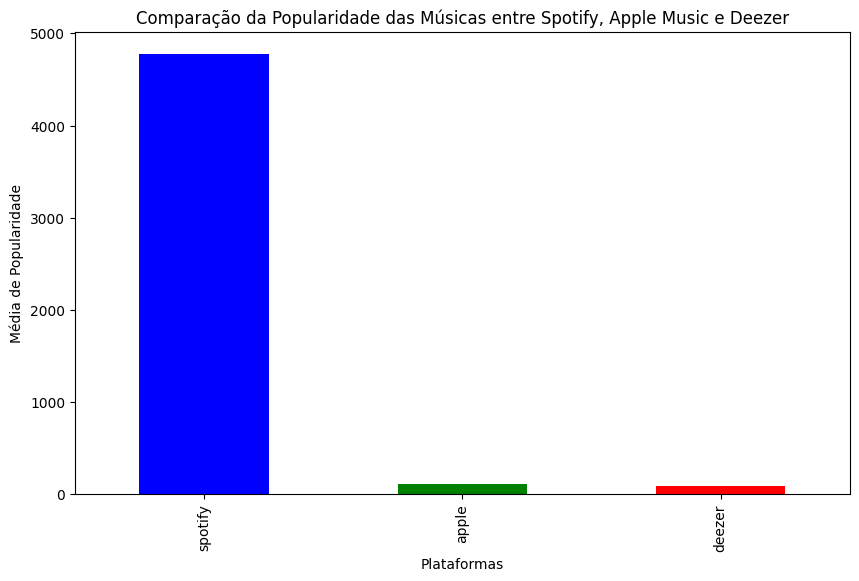

In [79]:
# Selecionar as colunas de interesse para popularidade em cada plataforma
platform_popularity_columns = ['in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists',
                               'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts']

# Comparar as músicas em cada plataforma (somar os valores de playlists e charts)
spotify_popularity = df['in_spotify_playlists'] + df['in_spotify_charts']
apple_popularity = df['in_apple_playlists'] + df['in_apple_charts']
deezer_popularity = df['in_deezer_playlists'] + df['in_deezer_charts']

# Criar DataFrame para armazenar as popularidades
platform_comparison = pd.DataFrame({
    'track_name': df['track_name'],
    'spotify': spotify_popularity,
    'apple': apple_popularity,
    'deezer': deezer_popularity
})

# Plotar gráfico de comparação
platform_comparison.set_index('track_name').mean().plot(kind='bar', figsize=(10, 6), color=['blue', 'green', 'red'])

plt.title('Comparação da Popularidade das Músicas entre Spotify, Apple Music e Deezer')
plt.xlabel('Plataformas')
plt.ylabel('Média de Popularidade')
plt.show()

In [80]:
# Agrupando os dados por artista e somando os streams
top_artistas = df.groupby('artist(s)_name')['streams'].sum().reset_index()

# Ordenando os artistas pelo total de streams e pegando os 5 principais
top_5_artistas = top_artistas.sort_values(by='streams', ascending=False).head(5)

print(top_5_artistas)

    artist(s)_name      streams
61       Bad Bunny  22248333516
583     The Weeknd  17605021888
171     Ed Sheeran  15034074801
563   Taylor Swift  12281081586
180         Eminem  10193727260


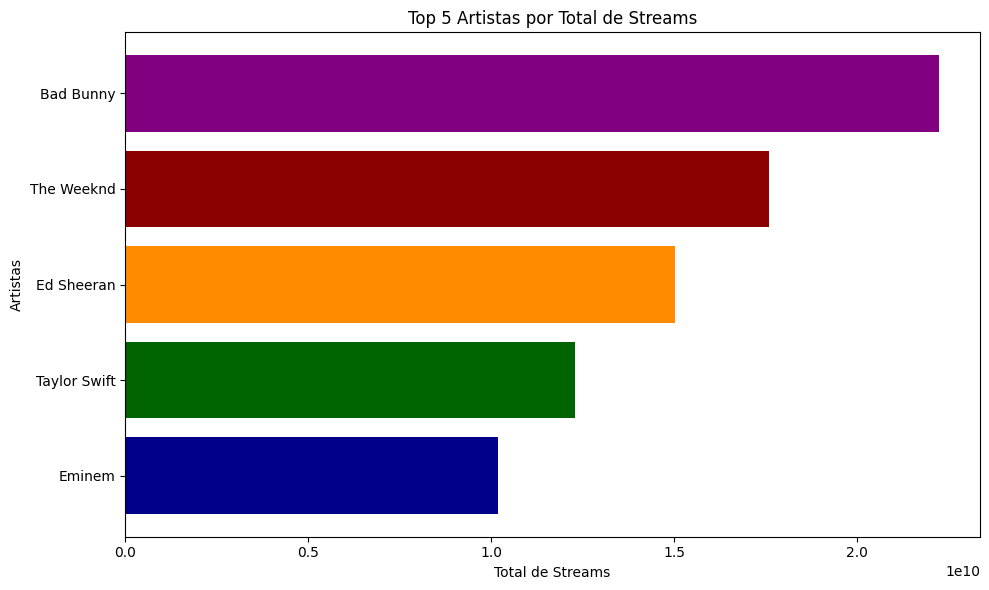

In [81]:
top_5_artistas_sorted = top_5_artistas.sort_values(by='streams')

plt.figure(figsize=(10, 6))
plt.barh(top_5_artistas_sorted['artist(s)_name'], top_5_artistas_sorted['streams'], color=['darkblue', 'darkgreen', 'darkorange', 'darkred', 'purple'])

plt.title('Top 5 Artistas por Total de Streams')
plt.xlabel('Total de Streams')
plt.ylabel('Artistas')
plt.tight_layout()

plt.show()

In [82]:
# Agrupando os dados por música e somando os streams, incluindo o nome do artista
top_musicas = df.groupby(['track_name', 'artist(s)_name'])['streams'].sum().reset_index()

# Ordenando as músicas pelo total de streams e pegando as 5 principais
top_5_musicas = top_musicas.sort_values(by='streams', ascending=False).head(5)

# Exibir o resultado
print(top_5_musicas)

                                         track_name artist(s)_name     streams
145                                 Blinding Lights     The Weeknd  3703895074
985                                    Shape of You     Ed Sheeran  3562543890
1023                              Someone You Loved  Lewis Capaldi  2887241814
264                                    Dance Monkey    Tones and I  2864791672
1062  Sunflower - Spider-Man: Into the Spider-Verse    Post Malone  2808096550


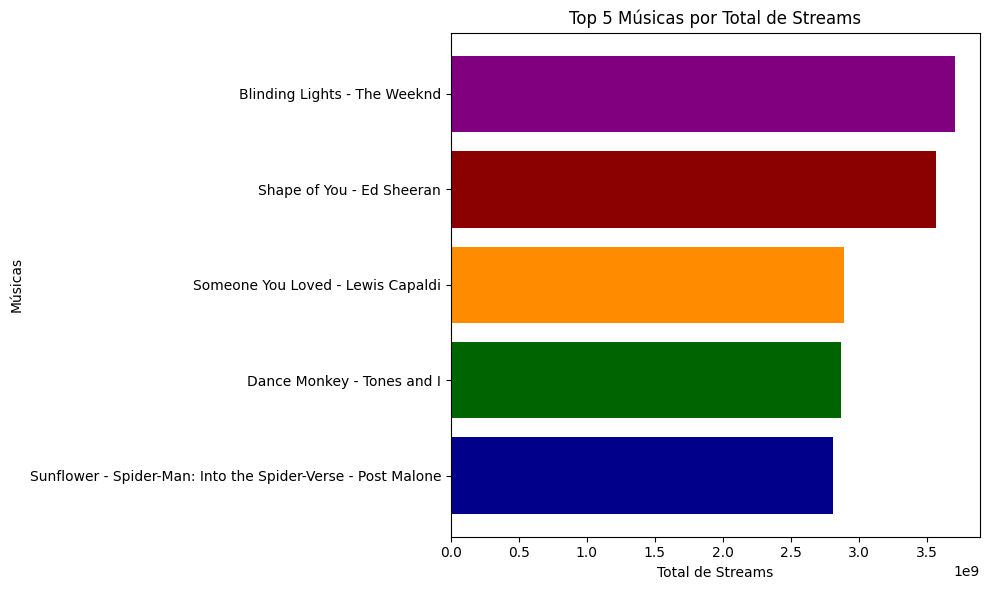

In [83]:
top_5_musicas_sorted = top_5_musicas.sort_values(by='streams')

plt.figure(figsize=(10, 6))
plt.barh(top_5_musicas_sorted['track_name'] + ' - ' + top_5_musicas_sorted['artist(s)_name'],
         top_5_musicas_sorted['streams'], color=['darkblue', 'darkgreen', 'darkorange', 'darkred', 'purple'])

plt.title('Top 5 Músicas por Total de Streams')
plt.xlabel('Total de Streams')
plt.ylabel('Músicas')
plt.tight_layout()

plt.show()

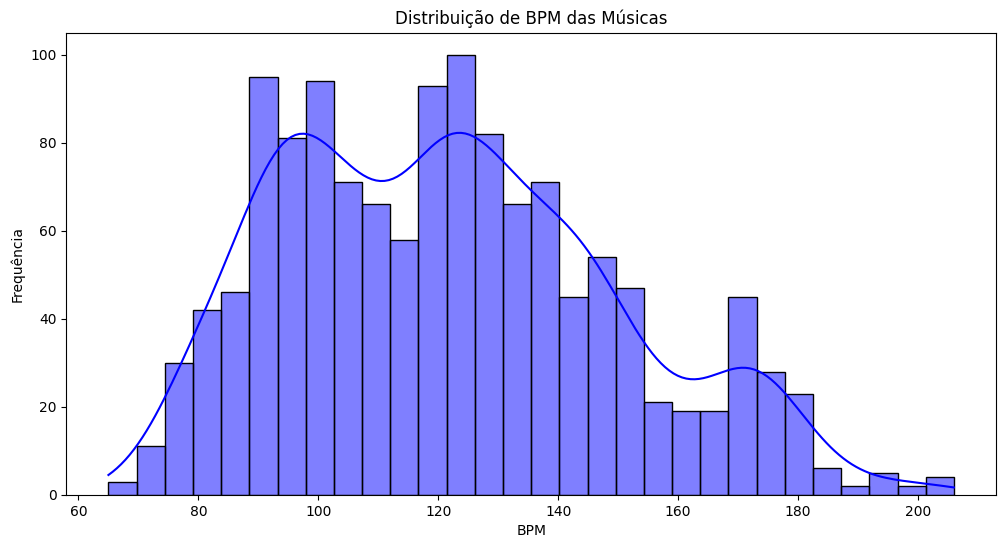

In [84]:
plt.figure(figsize=(12, 6))
sns.histplot(df['bpm'], bins=30, kde=True, color='blue')
plt.title('Distribuição de BPM das Músicas')
plt.xlabel('BPM')
plt.ylabel('Frequência')
plt.show()

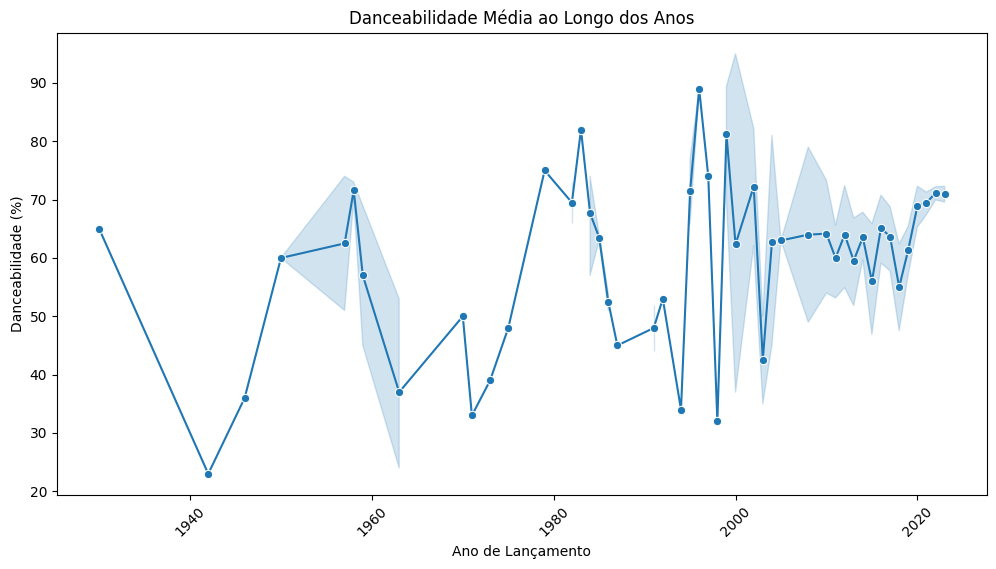

In [85]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='released_year', y='danceability_%', estimator='mean', marker='o')
plt.title('Danceabilidade Média ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Danceabilidade (%)')
plt.xticks(rotation=45)
plt.show()

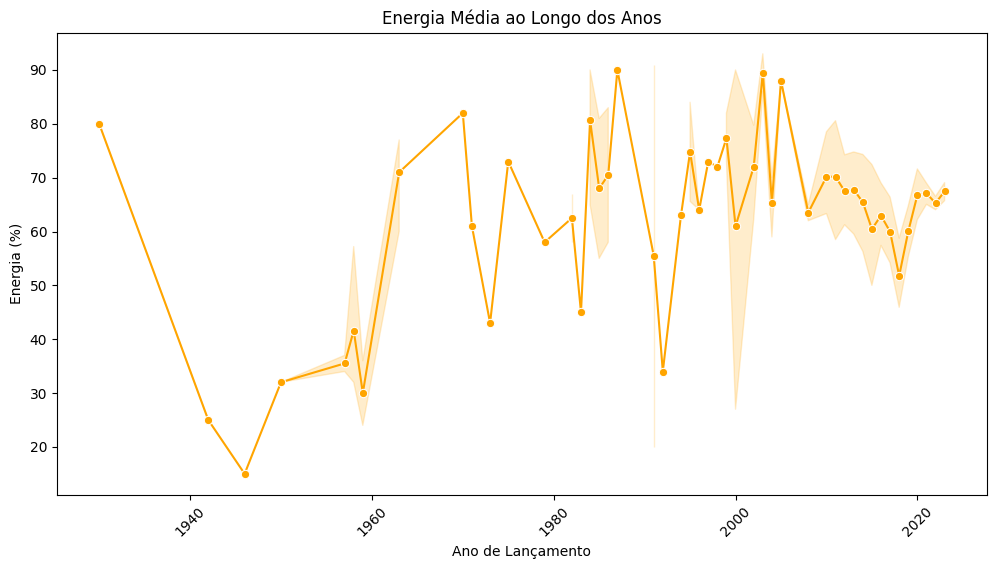

In [86]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='released_year', y='energy_%', estimator='mean', marker='o', color='orange')
plt.title('Energia Média ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Energia (%)')
plt.xticks(rotation=45)
plt.show()

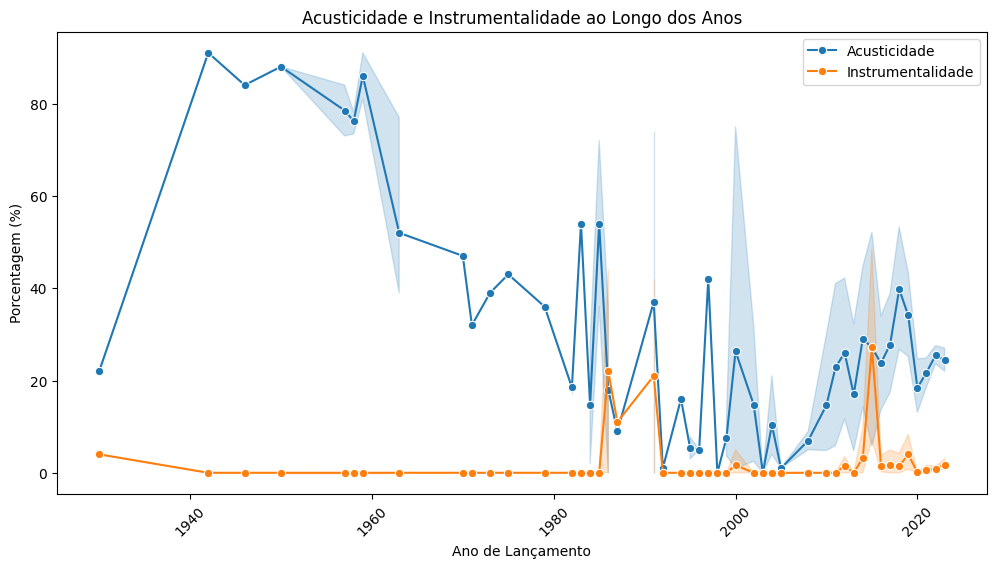

In [87]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='released_year', y='acousticness_%', estimator='mean', marker='o', label='Acusticidade')
sns.lineplot(data=df, x='released_year', y='instrumentalness_%', estimator='mean', marker='o', label='Instrumentalidade')
plt.title('Acusticidade e Instrumentalidade ao Longo dos Anos')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Porcentagem (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [88]:
# Declaração das colunas de áudio
audio_columns = [
    'bpm',                    # Batidas por minuto
    'key',                    # Tom da música
    'mode',                   # Modo da música (maior ou menor)
    'danceability_%',         # Percentual de danceabilidade
    'valence_%',              # Positividade do conteúdo musical
    'energy_%',               # Nível de energia percebido
    'acousticness_%',         # Quantidade de som acústico
    'instrumentalness_%',     # Quantidade de conteúdo instrumental
    'liveness_%',             # Presença de elementos de performance ao vivo
    'speechiness_%'           # Quantidade de palavras faladas
]


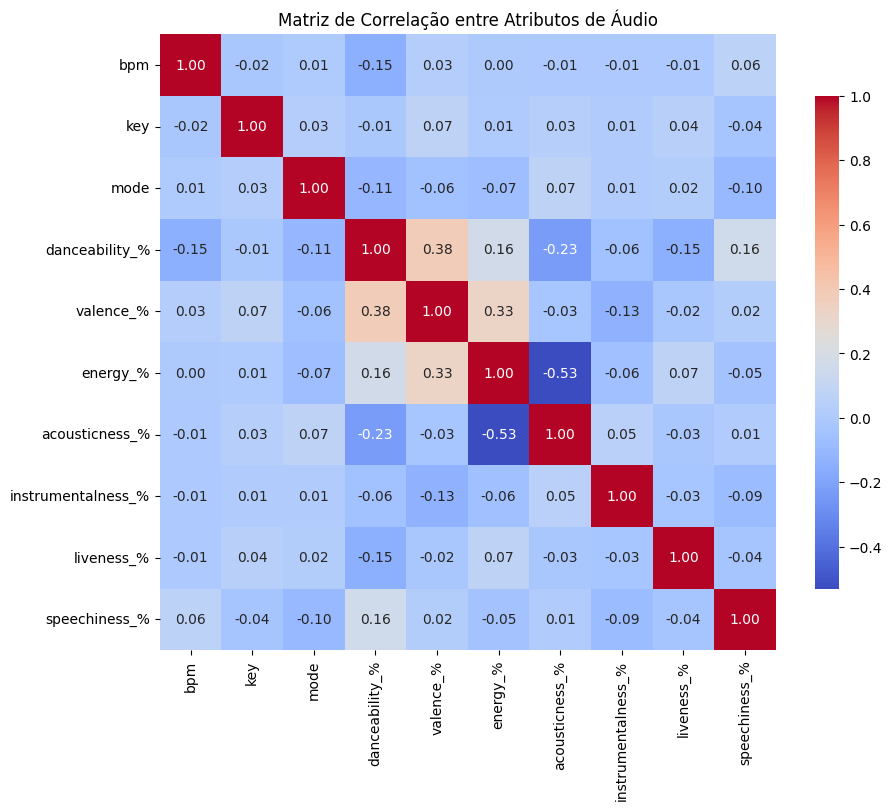

In [89]:
# Cálculo da matriz de correlação apenas para colunas de áudio
audio_correlation_matrix = df[audio_columns].corr()

# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(audio_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlação entre Atributos de Áudio')
plt.show()


### Modelo

In [90]:
# Selecionar as colunas numéricas relevantes para recomendação, incluindo 'key' e 'mode'
features = ['danceability_%', 'valence_%', 'energy_%', 'bpm', 'acousticness_%', 'instrumentalness_%', 'mode']

In [91]:
# Normalizar os dados para que fiquem na mesma escala
scaler = MinMaxScaler()
spotify_data_scaled = scaler.fit_transform(df[features])

In [92]:
# Calcular a similaridade de cosseno entre as músicas
similarity_matrix = cosine_similarity(spotify_data_scaled)

In [93]:
# Função para encontrar o índice de uma música pelo nome
def find_song_index(song_name):
    try:
        return df[df['track_name'].str.lower() == song_name.lower()].index[0]
    except IndexError:
        return None

# Função para recomendar músicas similares a uma música pelo nome e incluir o artista
def recommend_songs_by_name(song_name, n_recommendations=5):
    song_index = find_song_index(song_name)

    if song_index is None:
        return f"A música '{song_name}' não foi encontrada no dataset."

    # Obter as pontuações de similaridade da música especificada
    similarity_scores = list(enumerate(similarity_matrix[song_index]))

    # Ordenar as músicas com base na similaridade, exceto a própria música
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Selecionar as N músicas mais similares, removendo duplicatas
    recommended_songs = []
    seen_songs = set()

    for i in similarity_scores[1:]:
        song_title = df.iloc[i[0]]['track_name']
        artist_name = df.iloc[i[0]]['artist(s)_name']  # Incluindo o nome do artista
        if song_title not in seen_songs:
            recommended_songs.append((song_title, artist_name, i[1]))
            seen_songs.add(song_title)
        if len(recommended_songs) >= n_recommendations:
            break

    return recommended_songs

# Exemplo de recomendação: recomendar músicas similares a uma música pelo nome e artista
song_name = "vampire"  # Nome da música que você quer usar como base
recommended_songs = recommend_songs_by_name(song_name, 5)

# Exibir as recomendações com o nome do artista
if isinstance(recommended_songs, str):
    print(recommended_songs)
else:
    for song, artist, score in recommended_songs:
        print(f"Artista: {artist}, Track: {song}, Similiaridade: {score}")

Artista: ThxSoMch, Track: SPIT IN MY FACE!, Similiaridade: 0.9992200702746054
Artista: Harry Styles, Track: Adore You, Similiaridade: 0.997909175296723
Artista: Yung Gravy, Track: Betty (Get Money), Similiaridade: 0.9978663359161252
Artista: Taylor Swift, Track: Blank Space, Similiaridade: 0.9976681787592552
Artista: Feid, Track: En La De Ella, Similiaridade: 0.9968954460252306


O modelo de recomendação baseado em similaridade de conteúdo é ideal para esta base de dados, que contém atributos detalhados sobre as músicas, como dançabilidade, energia, valência, e bpm. Utilizando a similaridade de cosseno, o modelo encontra músicas com características sonoras semelhantes à faixa alvo, proporcionando recomendações precisas e personalizadas.

Ele é eficiente, escalável e evita duplicatas, tornando-o uma escolha simples, mas poderosa, para recomendar músicas que compartilham atributos musicais específicos. Além disso, o modelo pode ser facilmente ajustado ou combinado com outras técnicas, como filtragem colaborativa, para criar um sistema híbrido, aumentando ainda mais a personalização.